#Imports i classes

In [3]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import chess
import csv
import random
import matplotlib.pyplot as plt
import json

In [2]:
class bd_creator:
    def __init__(self) -> None:
        self.inputmeta = None
        self.inputboard = None
        self.data_labels = None
        self.data_test = None

    def boardstate(self, fen):
        try:
            board = chess.Board(str(fen.iloc[0]))
            fstr = str(fen.iloc[0])
        except ValueError as e:
            print("Error: Debes introducir un número válido.")
            return 0

        # Boolean to integer mappings
        WCKI = int(board.has_kingside_castling_rights(chess.WHITE))
        WCQ = int(board.has_queenside_castling_rights(chess.WHITE))
        WCH = int(board.is_check())
        BCKI = int(board.has_kingside_castling_rights(chess.BLACK))
        BCQ = int(board.has_queenside_castling_rights(chess.BLACK))
        BCH = int(board.was_into_check())

        fw = [WCKI, WCQ, WCH]
        fb = [BCKI, BCQ, BCH]

        # Piece to integer mapping
        piece_map = {
            'p': -1, 'n': -3, 'b': -4, 'r': -5, 'q': -9, 'k': -100,
            'P': 1, 'N': 3, 'B': 4, 'R': 5, 'Q': 9, 'K': 100, '.': 0
        }

        # Convert board to a list of integers
        bstr = [piece_map.get(char, 0) for char in str(board).replace('\n', '') if char in piece_map]

        # Flip the board if it's Black's turn
        if "w" not in fstr:
            bstr = [-piece for piece in bstr][::-1]
            fw, fb = fb, fw

        # Combine castling/check info with the board state
        BITBOARD = fw + fb + bstr

        return BITBOARD



    # Funcio que permet transformar una parella de tauler + evaluacio en un valor general
    # en cas que sigui jaque mate l'evalua com a 10000 o -10000 depenen del color que guanyi

    def strfix(self, fen, tr):

        fstr = str(fen)

        if '#' in str(tr):
            if '-' in tr:
                t = -10000
            else:
                t = 10000
        elif '\ufeff+23' in str(tr):
            t = 0
        else:
            t = int(tr)

        if "w" not in fstr:
            t = t*-1
        return t


    def train_data(self, nrows):
        self.seleccionar_lineas_aleatorias("drive/MyDrive/TFG/chessData.csv", "drive/MyDrive/TFG/rand_lines_data.csv", nrows)

        data = pd.read_csv("drive/MyDrive/TFG/rand_lines_data.csv")

        # creem array de labels per la red neruronal
        data_labels = data
        data_labels.columns = ['col1', 'col2']
        data_labels = data_labels.astype(str)
        self.data_labels = data_labels.apply(lambda x: self.strfix(x['col1'], x['col2']), axis=1)

        # creem les dades que permetran entrenar a la red neuronal
        label_columns = [1]
        data_features = data.drop(columns=data.iloc[:, label_columns])
        data_features = data_features.apply(self.boardstate, axis=1)
        data_features = data_features.apply(pd.Series)


        # gardem en un array el input del taulell
        input2_columns = [0, 1, 2, 3, 4, 5]
        inputboard = data_features.drop(columns=data_features.iloc[:, input2_columns])

        self.inputboard = np.array(inputboard)

        # guardem en un array el input de la info del estat
        inputmeta = data_features.iloc[:, input2_columns]

        self.inputmeta = np.array(inputmeta)


    def test_data(self, nrows):

        self.seleccionar_lineas_aleatorias("drive/MyDrive/TFG/chessData.csv", "drive/MyDrive/TFG/rand_lines_data.csv", nrows)

        data = pd.read_csv("drive/MyDrive/TFG/rand_lines_data.csv")

        # creem array de labels per la red neruronal
        data_labels = data
        data_labels.columns = ['col1', 'col2']
        data_labels = data_labels.astype(str)
        self.data_labels = data_labels.apply(lambda x: self.strfix(x['col1'], x['col2']), axis=1)

        # creem les dades que permetran entrenar a la red neuronal
        label_columns = [1]
        data_features = data.drop(columns=data.iloc[:, label_columns])
        data_features = data_features.apply(self.boardstate, axis=1)
        data_features = data_features.apply(pd.Series)


        # gardem en un array el input del taulell
        input2_columns = [0, 1, 2, 3, 4, 5]
        inputboard = data_features.drop(columns=data_features.iloc[:, input2_columns])

        self.inputboard = np.array(inputboard)

        # guardem en un array el input de la info del estat
        inputmeta = data_features.iloc[:, input2_columns]

        self.inputmeta = np.array(inputmeta)

        return (self.inputboard, self.inputmeta, self.data_labels)

    def seleccionar_lineas_aleatorias(self, input_file, output_file, num_lines):
        # Definir los intervalos de evaluación
        num_lines_per_interval = int(num_lines / 4)
        intervals = {
            "[-1000, -500)": [],
            "[-500, 0)": [],
            "[0, 500)": [],
            "[500, 1000]": [],
        }
        extra = []

        # Leer el archivo de entrada
        with open(input_file, 'r') as infile:
            reader = csv.reader(infile)
            header = next(reader)  # Leer el encabezado si existe

            for line in reader:
                # Asumimos que la evaluación está en la última columna y es numérica
                try:
                    evaluation = int(line[-1])
                except ValueError:
                    continue  # Si no se puede convertir a float, se omite la línea

                # Clasificar la línea en el intervalo correspondiente
                if -100000 <= evaluation < -1000:
                    intervals["[-1000, -500)"].append(line)
                elif -1000 <= evaluation < 0:
                    intervals["[-500, 0)"].append(line)
                elif 0 <= evaluation < 1000:
                    intervals["[0, 500)"].append(line)
                elif 1000 <= evaluation <= 100000:
                    intervals["[500, 1000]"].append(line)

        # Seleccionar num_lines_per_interval de cada interval
        selected_lines = []
        for interval, lines in intervals.items():
            if len(lines) < num_lines_per_interval:
                print(f"Warning: not enough lines in interval {interval}")
                selected_lines.extend(lines)
            else:
                selected_lines.extend(random.sample(lines, num_lines_per_interval))


        # Guardar las líneas seleccionadas en el archivo de salida
        with open(output_file, 'w', newline='') as outfile:
            writer = csv.writer(outfile)
            writer.writerow(header)  # Escribir el encabezado
            writer.writerows(selected_lines)

    def train_test(self, nrows, test_size=0.2):

        self.seleccionar_lineas_aleatorias("/content/drive/MyDrive/TFG/chessData.csv", "/content/drive/MyDrive/TFG/rand_lines_data.csv", nrows)

        data = pd.read_csv("/content/drive/MyDrive/TFG/rand_lines_data.csv")
        # creem array de labels per la red neruronal
        data_labels = data
        data_labels.columns = ['col1', 'col2']
        data_labels = data_labels.astype(str)
        data_labels = data_labels.apply(lambda x: self.strfix(x['col1'], x['col2']), axis=1)
        self.data_labels = np.array(data_labels)

        # creem les dades que permetran entrenar a la red neuronal
        label_columns = [1]
        data_features = data.drop(columns=data.iloc[:, label_columns])
        data_features = data_features.apply(self.boardstate, axis=1)
        data_features = data_features.apply(pd.Series)


        # gardem en un array el input del taulell
        input2_columns = [0, 1, 2, 3, 4, 5]
        inputboard = data_features.drop(columns=data_features.iloc[:, input2_columns])

        self.inputboard = np.array(inputboard)

        # guardem en un array el input de la info del estat
        inputmeta = data_features.iloc[:, input2_columns]

        self.inputmeta = np.array(inputmeta)


        im_train, im_test, lab_train, lab_test = train_test_split(self.inputmeta, self.data_labels, test_size=test_size, random_state=123)
        ib_train, ib_test, _, _ = train_test_split(self.inputboard, self.data_labels, test_size=test_size, random_state=123)
        return (im_train, im_test, ib_train, ib_test, lab_train, lab_test)

In [3]:
data = bd_creator()

In [25]:
metric = [tf.keras.metrics.MeanAbsoluteError()]
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
los = tf.keras.losses.MeanSquaredError()

# ANALISIS DATA

In [6]:
data = bd_creator()
im_train, im_test, ib_train, ib_test, lab_train, lab_test = data.train_test(1000)

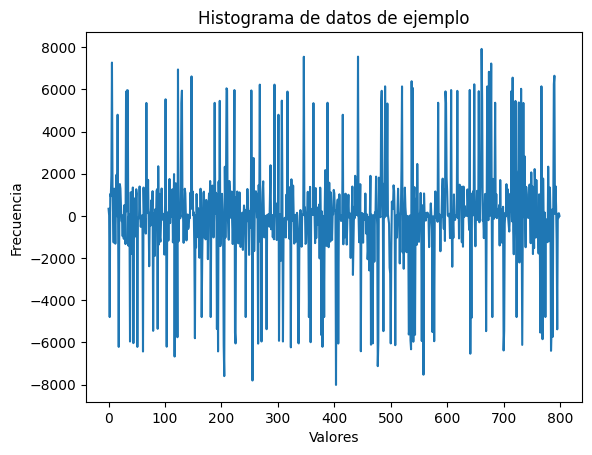

In [7]:
# Crear el histograma
plt.plot(lab_train)

# Agregar título y etiquetas
plt.title('Histograma de datos de ejemplo')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

In [8]:
lab_train.sort()
print(lab_train)

[-8014 -7805 -7596 -7530 -7124 -6669 -6534 -6430 -6425 -6418 -6397 -6380
 -6325 -6233 -6211 -6211 -6207 -6202 -6147 -6130 -6116 -6107 -6056 -6052
 -6047 -6047 -6047 -6047 -6033 -6002 -5989 -5966 -5961 -5956 -5956 -5956
 -5942 -5933 -5923 -5902 -5846 -5800 -5753 -5736 -5650 -5636 -5622 -5550
 -5531 -5509 -5464 -5464 -5454 -5450 -5378 -5373 -5364 -5364 -5359 -5354
 -4841 -4797 -4797 -4796 -4796 -4796 -4796 -4796 -4795 -4795 -2799 -2729
 -2585 -2507 -2455 -2411 -2388 -2254 -2210 -2171 -2135 -2055 -2051 -2016
 -1992 -1991 -1985 -1934 -1896 -1851 -1843 -1836 -1819 -1811 -1809 -1784
 -1725 -1722 -1677 -1669 -1665 -1643 -1614 -1603 -1570 -1527 -1500 -1486
 -1484 -1480 -1475 -1462 -1461 -1440 -1434 -1423 -1407 -1403 -1374 -1361
 -1360 -1348 -1337 -1334 -1330 -1319 -1314 -1304 -1300 -1294 -1292 -1277
 -1273 -1270 -1269 -1267 -1262 -1254 -1253 -1249 -1248 -1234 -1234 -1230
 -1223 -1221 -1217 -1217 -1207 -1206 -1205 -1205 -1201 -1196 -1189 -1187
 -1182 -1177 -1169 -1163 -1144 -1142 -1131 -1121 -1

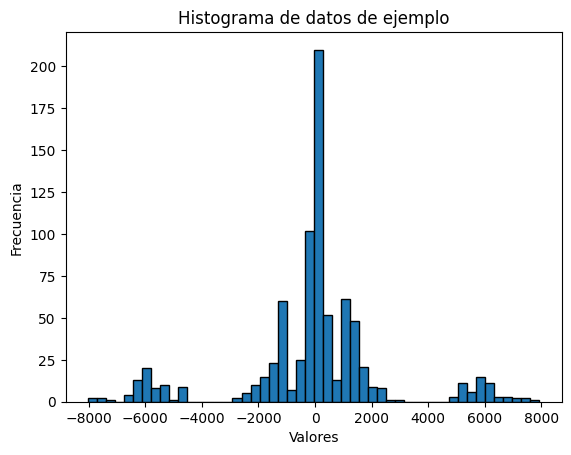

In [9]:
# Crear el histograma
plt.hist(lab_train, bins=50, edgecolor='black')

# Agregar título y etiquetas
plt.title('Histograma de datos de ejemplo')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

# Entrenament amb eraly_stopping

In [ ]:
data_model = tf.keras.models.load_model('/content/drive/MyDrive/TFG/model_200_model_gran.h5',
                                   custom_objects={'InputLayer': tf.keras.layers.InputLayer,
                                                   'MeanSquaredError': tf.keras.losses.MeanSquaredError})
data_model.compile(optimizer=opt, loss=los, metrics=metric)

In [21]:
im_train, im_test, ib_train, ib_test, lab_train, lab_test = data.train_test(100000)


In [22]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
 epochs = 100

# Entrenar el modelo
history = data_model.fit([ib_train, im_train], lab_train, shuffle=True,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=16)

Epoch 1/100
4000/4000 [==============================] - 102s 25ms/step - loss: 3821844.5000 - mean_absolute_error: 1286.5496 - val_loss: 3744630.5000 - val_mean_absolute_error: 1209.7621
Epoch 2/100
4000/4000 [==============================] - 94s 23ms/step - loss: 3812282.5000 - mean_absolute_error: 1286.6710 - val_loss: 3606118.2500 - val_mean_absolute_error: 1171.7285
Epoch 3/100
4000/4000 [==============================] - 97s 24ms/step - loss: 3785227.0000 - mean_absolute_error: 1281.3848 - val_loss: 3625965.0000 - val_mean_absolute_error: 1174.7529
Epoch 4/100
4000/4000 [==============================] - 97s 24ms/step - loss: 3777642.5000 - mean_absolute_error: 1281.7726 - val_loss: 3621851.7500 - val_mean_absolute_error: 1177.7429
Epoch 5/100
4000/4000 [==============================] - 96s 24ms/step - loss: 3765104.5000 - mean_absolute_error: 1277.4242 - val_loss: 3556412.5000 - val_mean_absolute_error: 1194.4143
Epoch 6/100
4000/4000 [==============================] - 96s 24m

KeyboardInterrupt: 

In [ ]:
total_epochs = 300
data_model.save("/content/drive/MyDrive/TFG/model_"+str(total_epochs)+"_model_gran.h5")
print("\n Model saves as: model_"+str(total_epochs)+".weights.h5")

# guardar y cargar historico

In [ ]:


# Tu diccionario
mi_diccionario = history.history

# Guardar en un archivo JSON
with open('/content/drive/MyDrive/TFG/history-0-200_0.005.json', 'w') as archivo:
    json.dump(mi_diccionario, archivo)
print("history saved")

In [ ]:
# Cargar el diccionario desde el archivo JSON
with open('/content/drive/MyDrive/TFG/history-0-200.json', 'r') as archivo:
    history = json.load(archivo)

#Model sense conv

In [ ]:
input1 = tf.keras.layers.Input(shape=(64,))
input2 = tf.keras.layers.Input(shape=(6,))

conc = tf.keras.layers.concatenate([input1, input2])

# Dense layers with regularization and dropout
Denselayer1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(conc)
Denselayer1 = tf.keras.layers.BatchNormalization()(Denselayer1)
Denselayer1 = tf.keras.layers.Dropout(0.5)(Denselayer1)

Denselayer2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(Denselayer1)
Denselayer2 = tf.keras.layers.BatchNormalization()(Denselayer2)
Denselayer2 = tf.keras.layers.Dropout(0.5)(Denselayer2)

Denselayer3 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(Denselayer2)
Denselayer3 = tf.keras.layers.BatchNormalization()(Denselayer3)
Denselayer3 = tf.keras.layers.Dropout(0.5)(Denselayer3)

Denselayer4 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(Denselayer3)
Denselayer4 = tf.keras.layers.BatchNormalization()(Denselayer4)
Denselayer4 = tf.keras.layers.Dropout(0.5)(Denselayer4)

Denselayer5 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(Denselayer4)
Denselayer5 = tf.keras.layers.BatchNormalization()(Denselayer5)
Denselayer5 = tf.keras.layers.Dropout(0.5)(Denselayer5)

Output = tf.keras.layers.Dense(1, activation='linear')(Denselayer5)

data_model = tf.keras.models.Model(inputs=[input1, input2], outputs=Output)

In [ ]:
data_model.compile(optimizer=opt, loss=los,  metrics=metric)
data_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 70)                   0         ['input_3[0][0]',             
 )                                                                   'input_4[0][0]']             
                                                                                                  
 dense_4 (Dense)             (None, 128)                  9088      ['concatenate_1[0][0]']   

# 0.3 dropout / 50 epoch / 200k dades


In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

# 0.5 dropout / 50  epoch / 200k dades

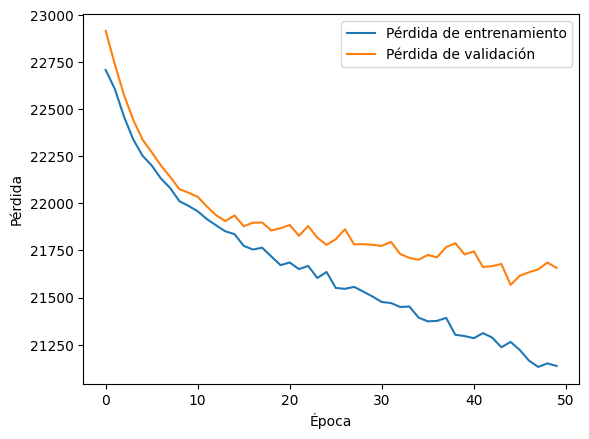

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 66.43233975231726
Error Cuadrático Medio (MSE): 21170.492609815676


In [ ]:
lab_test

array([232.6,  14.1,  -6.9, ...,  -4.9,  81. ,  59.9])

In [ ]:
print(predictions)

[ 55.177765  56.53286  -17.235018 ...  13.494099  50.211704 -13.891042]


# 0.5 dropout - 0.01 l2 / 50  epoch / 200k dades

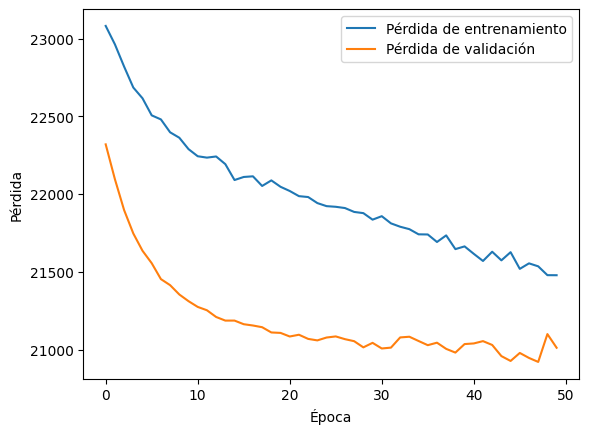

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 67.38325824870327
Error Cuadrático Medio (MSE): 22051.41535514002


# 0.5 dropout / 100  epoch / 200k dades

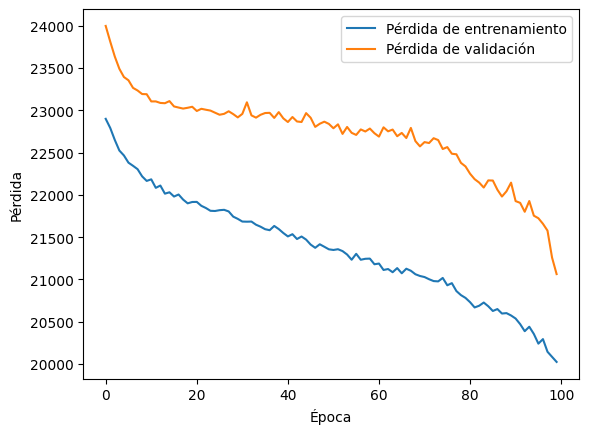

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 63.09231432359517
Error Cuadrático Medio (MSE): 20049.873905341075


# 0.5 dropout / 100  epoch / 400k dades

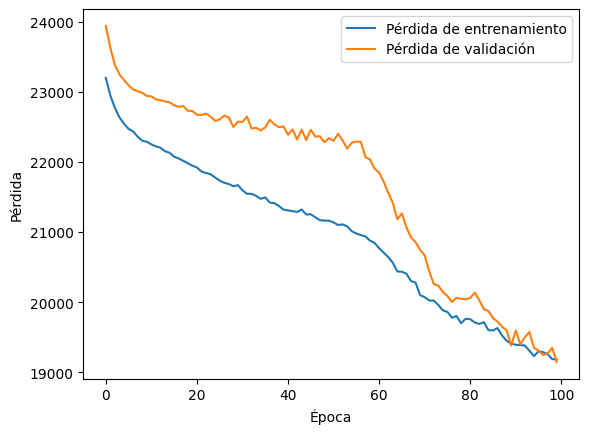

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 59.895882178844815
Error Cuadrático Medio (MSE): 19224.436363452256


# 0.5 dropout / 100  epoch / 400k dades

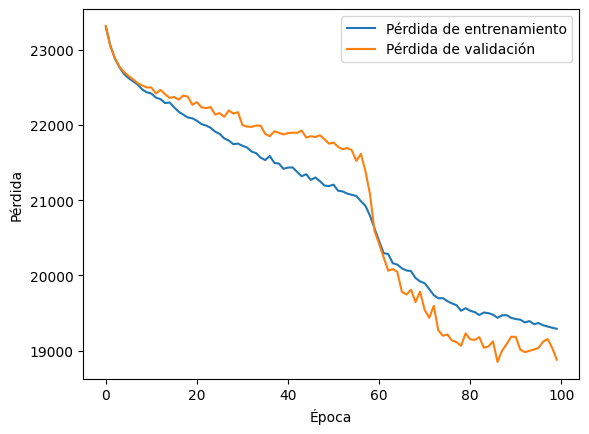

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 58.80044760546827
Error Cuadrático Medio (MSE): 18553.18717976597


# 0.5 dropout / 200  epoch / 400k dades

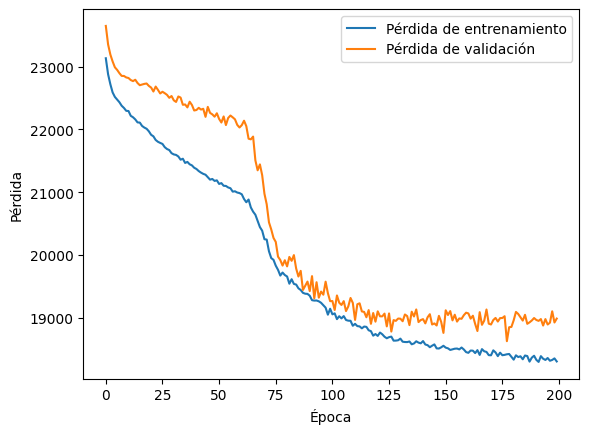

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 57.1648039146018
Error Cuadrático Medio (MSE): 16845.600913072984


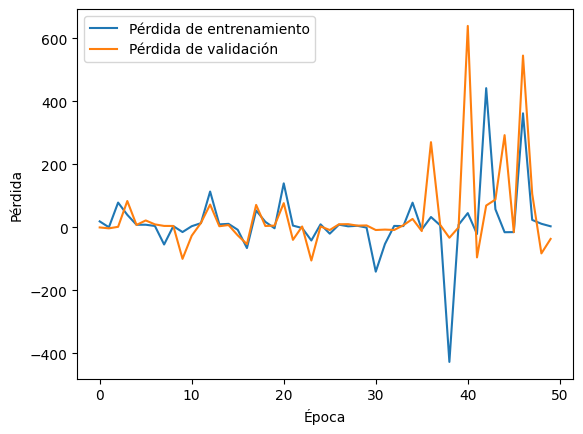

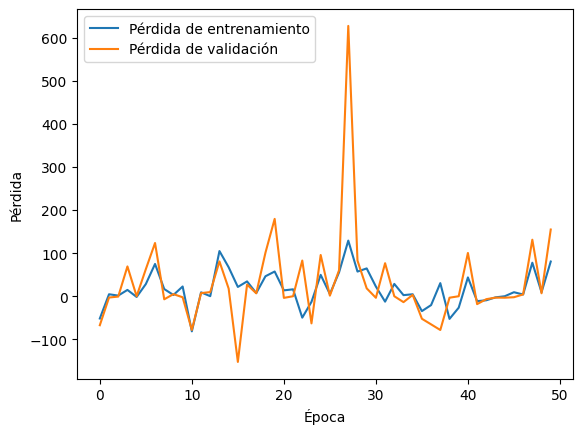

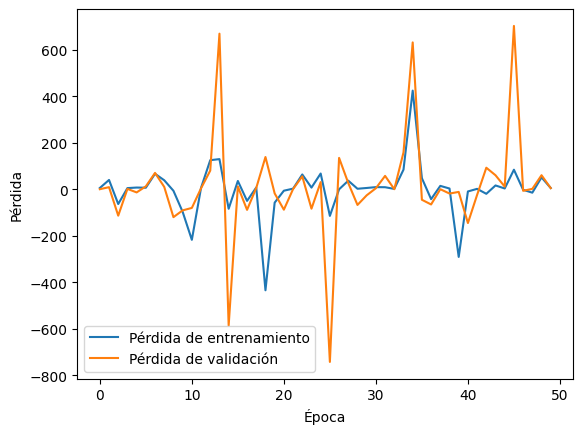

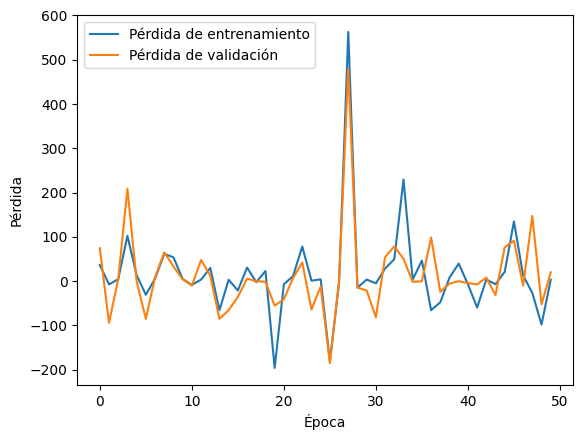

In [ ]:
for i in range(6,10):
    # Graficar las pérdidas
    x = 50*i
    plt.plot(predictions[x:x+50], label='Pérdida de entrenamiento')
    plt.plot(lab_test[x:x+50], label='Pérdida de validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

# 0.5 dropout / 250  epoch / 400k dades

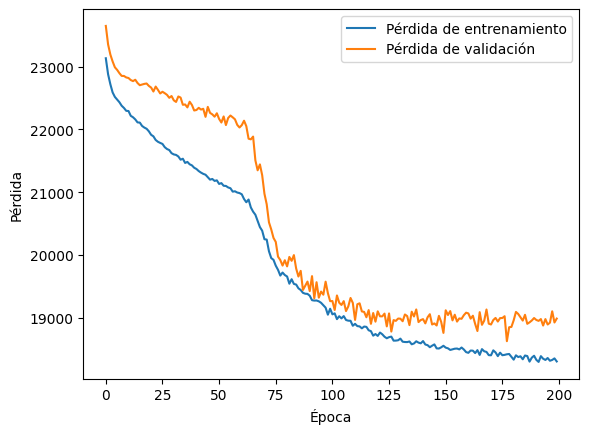

In [ ]:
# Graficar las pérdidas
plt.plot(history['loss'], label='Pérdida de entrenamiento')
plt.plot(history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

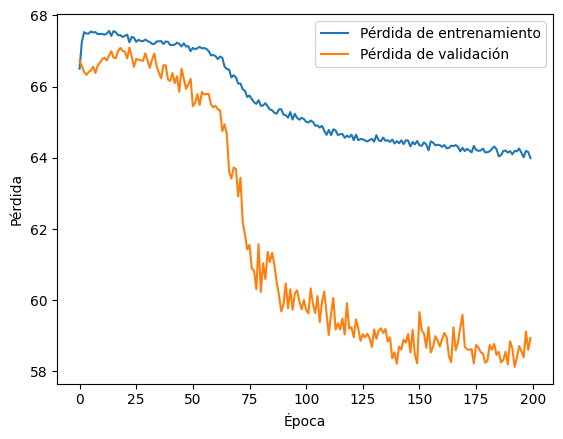

In [ ]:
# Graficar las pérdidas
plt.plot(history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 58.44513387687928
Error Cuadrático Medio (MSE): 19001.904220525732


# 0.5 dropout / 0.005 l2 / 50 epoch / 800k dades


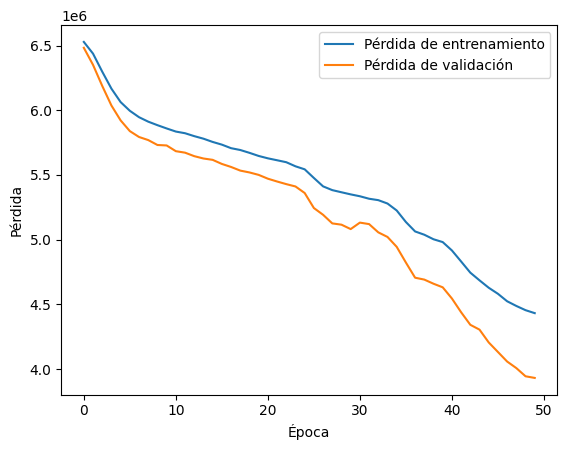

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

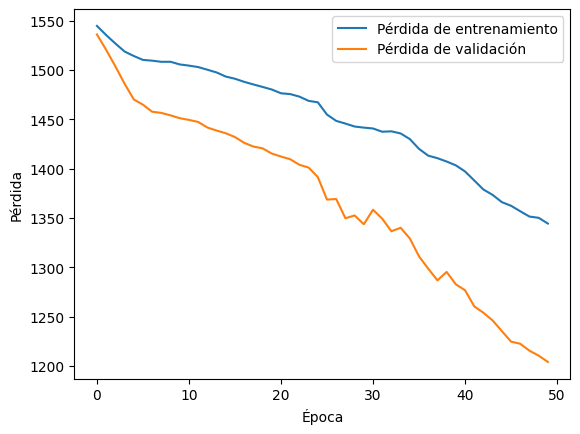

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 1451.9319174682378
Error Cuadrático Medio (MSE): 5720611.578637665


In [ ]:
predictions

array([-7.6783337e+02,  1.7074527e+02,  1.4921417e+03, ...,
       -3.7771460e+03,  1.0669416e+00, -2.5266142e+02], dtype=float32)

In [ ]:
print(lab_test)

[-5942   107  6338 ... -2570   282 -1669]


# Model gran

In [ ]:
input1 = tf.keras.layers.Input(shape=(64,))
shape1 = tf.keras.layers.Reshape(target_shape=(8, 8, 1))(input1)
conv1 = tf.keras.layers.Conv2D(kernel_size=(3,3), padding="same", activation="relu", filters=64)(shape1)
bn1 = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-05)(conv1)
flatten1 = tf.keras.layers.Flatten()(bn1)

input2 = tf.keras.layers.Input(shape=(6,))

conc = tf.keras.layers.concatenate([flatten1, input2])

# Dense layers with regularization and dropout
Denselayer1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(conc)
Denselayer1 = tf.keras.layers.BatchNormalization()(Denselayer1)
Denselayer1 = tf.keras.layers.Dropout(0.3)(Denselayer1)

Denselayer2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(Denselayer1)
Denselayer2 = tf.keras.layers.BatchNormalization()(Denselayer2)
Denselayer2 = tf.keras.layers.Dropout(0.3)(Denselayer2)

Denselayer3 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(Denselayer2)
Denselayer3 = tf.keras.layers.BatchNormalization()(Denselayer3)
Denselayer3 = tf.keras.layers.Dropout(0.3)(Denselayer3)

Denselayer4 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(Denselayer3)
Denselayer4 = tf.keras.layers.BatchNormalization()(Denselayer4)
Denselayer4 = tf.keras.layers.Dropout(0.3)(Denselayer4)

Denselayer5 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(Denselayer4)
Denselayer5 = tf.keras.layers.BatchNormalization()(Denselayer5)
Denselayer5 = tf.keras.layers.Dropout(0.3)(Denselayer5)

Output = tf.keras.layers.Dense(1, activation='linear')(Denselayer3)

data_model = tf.keras.models.Model(inputs=[input1, input2], outputs=Output)



In [ ]:
data_model.compile(optimizer=opt, loss=los, metrics=metric)


In [ ]:
data_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 8, 8, 1)              0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 8, 8, 64)             640       ['reshape[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 8, 8, 64)             256       ['conv2d[0][0]']              
 Normalization)                                                                               

# 100 epoch / 100k dades / 5x5 conv / 0.5 dropout / 0.001 l2

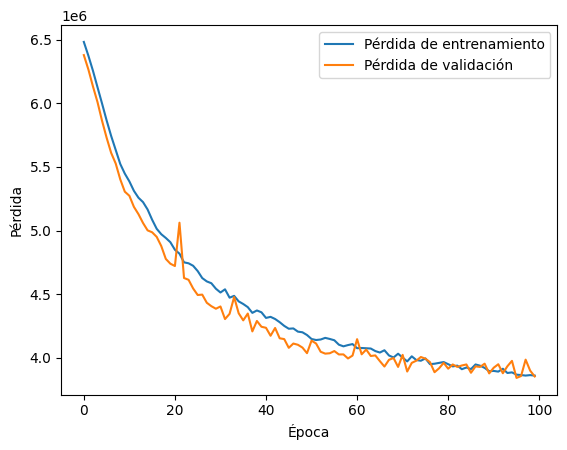

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

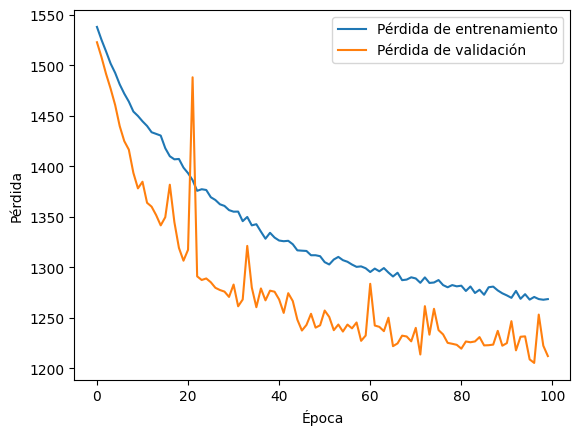

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 1230.1207821792364
Error Cuadrático Medio (MSE): 3956187.907740973


# 100 epoch / 200k dades / 5x5 conv / 0.5 dropout / 0.001 l2

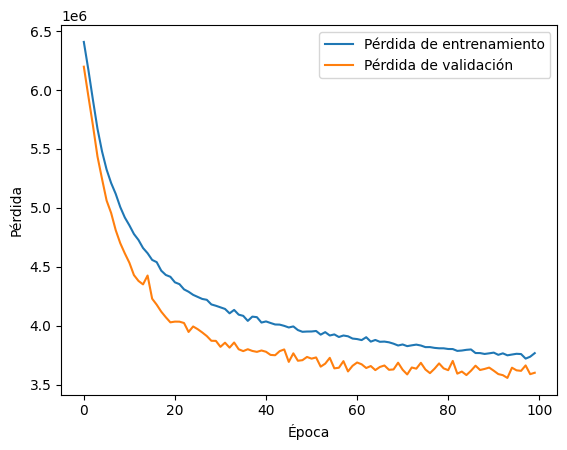

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

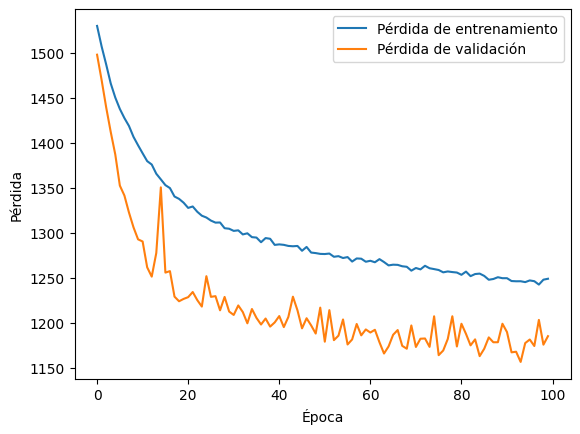

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 1202.1859075696543
Error Cuadrático Medio (MSE): 3685477.464422856


#100 epoch / 200k dades / 5x5 conv / 0.5 dropout / 0.01 l2

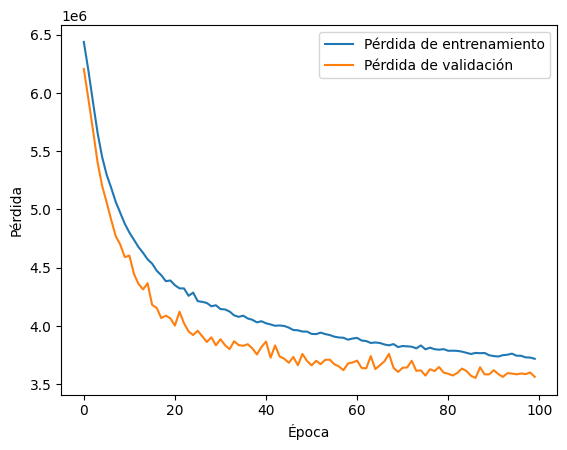

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

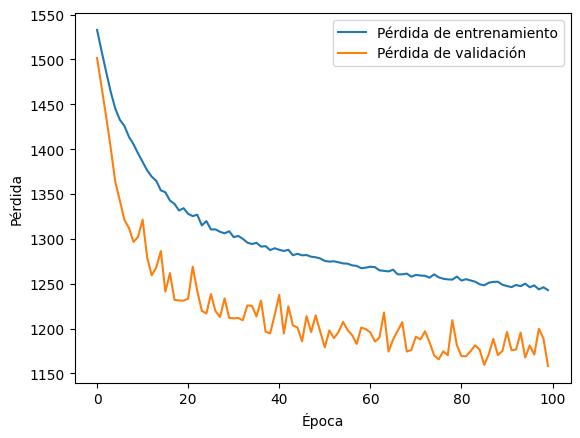

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 1170.9662870856866
Error Cuadrático Medio (MSE): 3649920.3098527147


#100 epoch / 200k dades / 5x5 conv / No dropout / 0.01 l2

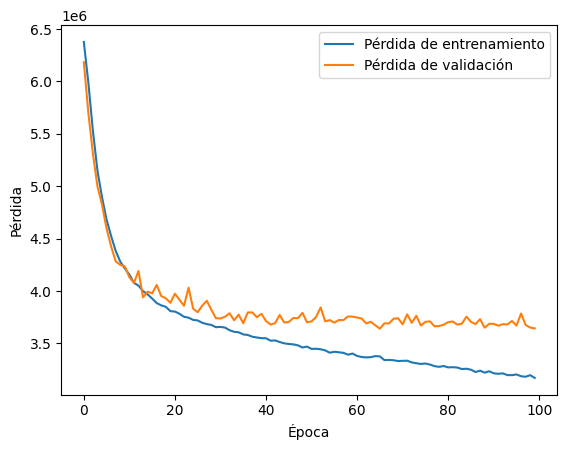

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

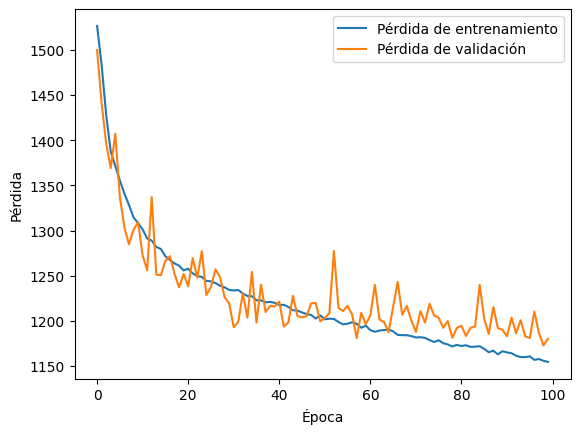

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 1188.0374402030534
Error Cuadrático Medio (MSE): 3712053.713657144


#100 epoch / 200k dades / 3x3 conv / 0.3 dropout / 0.01 l2

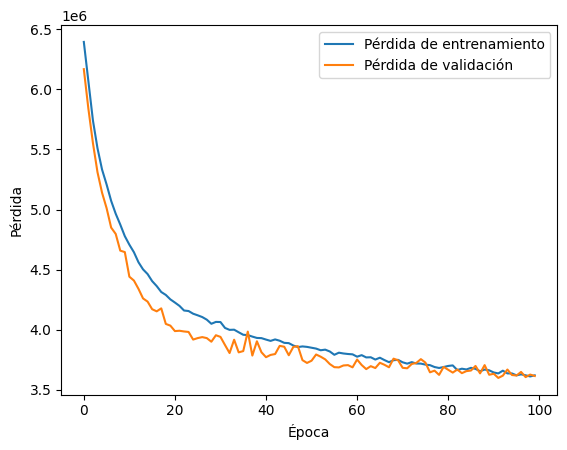

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

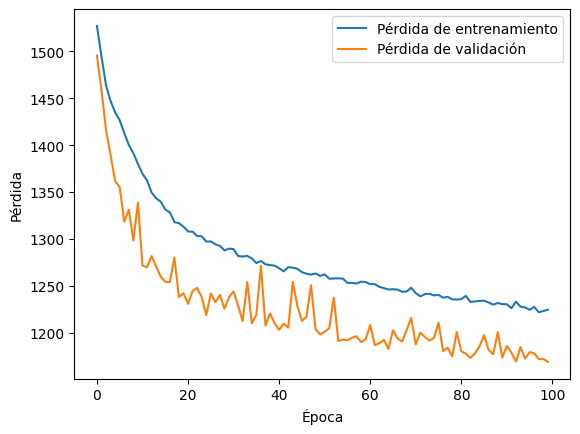

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 1159.6405096099909
Error Cuadrático Medio (MSE): 3530000.7143080435


#50 epoch / 800k dades / 3x3 conv / 0.3 dropout / 0.01 l2


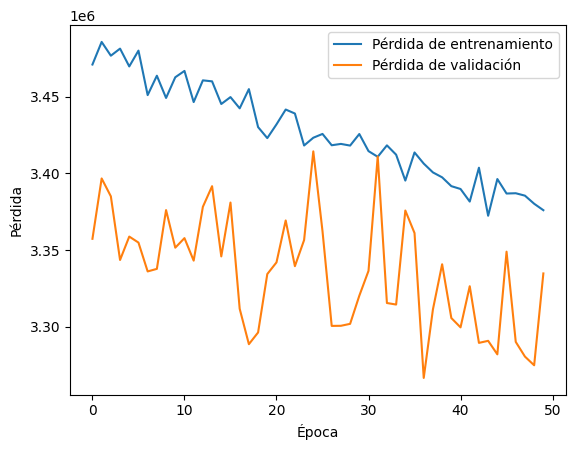

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

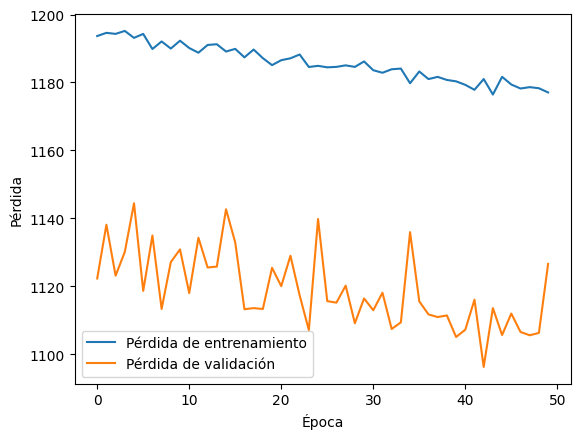

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 1125.322892738278
Error Cuadrático Medio (MSE): 3276984.8592239395


#100 epoch / 200k dades / 3x3 conv / 0.3 dropout / 0 l2

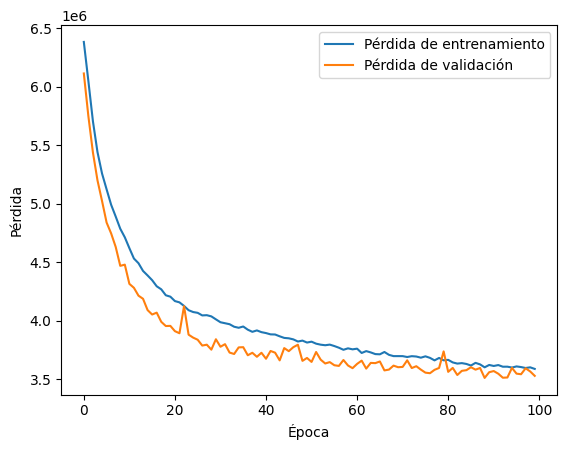

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

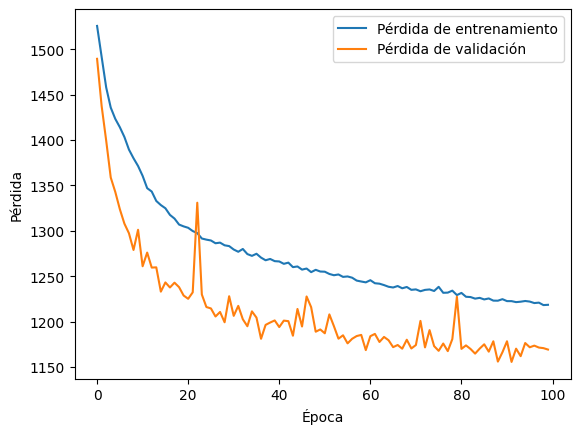

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 1181.2492229835786
Error Cuadrático Medio (MSE): 3594451.2838980393


#100 epoch / 200k dades / 3x3 conv / 0.3 dropout / 0.01 l2 / 0.001 LR

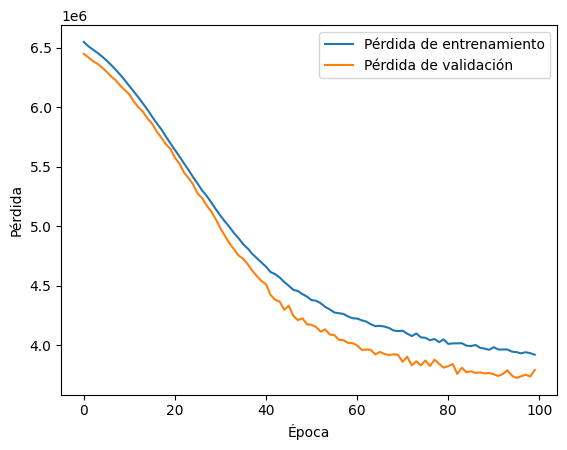

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

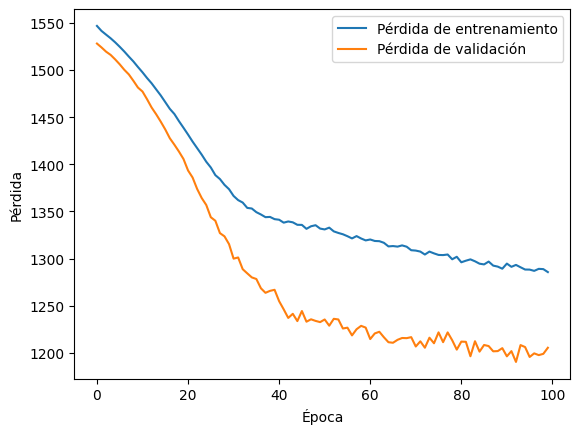

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

#100 epoch / 800k dades / 3x3 conv / 0.3 dropout / 0.01 l2

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

# Model Chat

In [24]:
input1 = tf.keras.layers.Input(shape=(64,))
shape1 = tf.keras.layers.Reshape(target_shape=(8, 8, 1))(input1)
conv1 = tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu")(shape1)
conv2 = tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu")(conv1)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
bn1 = tf.keras.layers.BatchNormalization()(pool1)
flatten1 = tf.keras.layers.Flatten()(bn1)

input2 = tf.keras.layers.Input(shape=(6,))

conc = tf.keras.layers.concatenate([flatten1, input2])

# Capas densas simplificadas con regularización fuerte
Denselayer1 = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(conc)
Denselayer1 = tf.keras.layers.BatchNormalization()(Denselayer1)
Denselayer1 = tf.keras.layers.Dropout(0.5)(Denselayer1)

Denselayer2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(Denselayer1)
Denselayer2 = tf.keras.layers.BatchNormalization()(Denselayer2)
Denselayer2 = tf.keras.layers.Dropout(0.5)(Denselayer2)

Output = tf.keras.layers.Dense(1, activation='linear')(Denselayer2)

In [26]:
data_model.compile(optimizer=opt, loss=los, metrics=metric)

In [19]:
data_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 8, 8, 1)              0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 8, 8, 64)             640       ['reshape[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 128)            73856     ['conv2d[0][0]']              
                                                                                              

# 100 epoch / 200k dades / 3x3 conv / 0.4 dropout / 0.01 l2


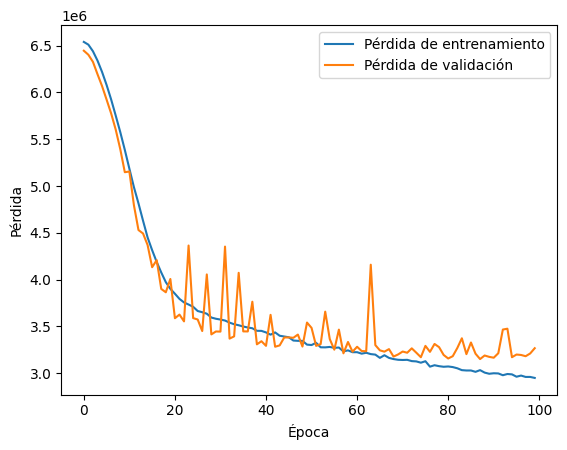

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

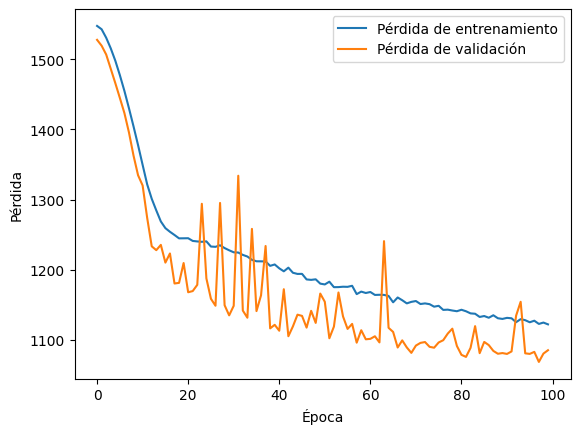

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 1100.5813670686887
Error Cuadrático Medio (MSE): 3312577.0110338326


# 100 epoch / 200k dades / 3x3 conv / 0.4 dropout / 0.01 l2 / 32 batch

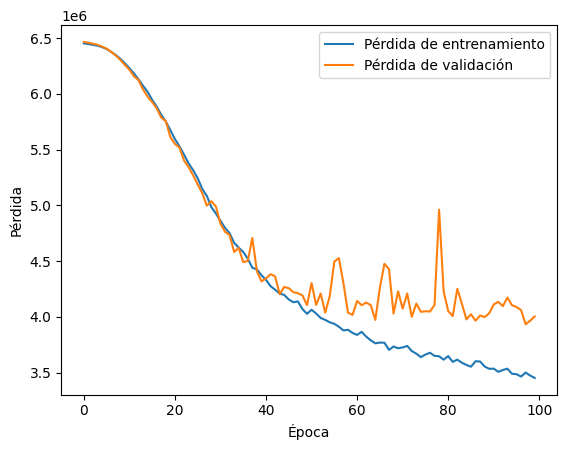

In [11]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

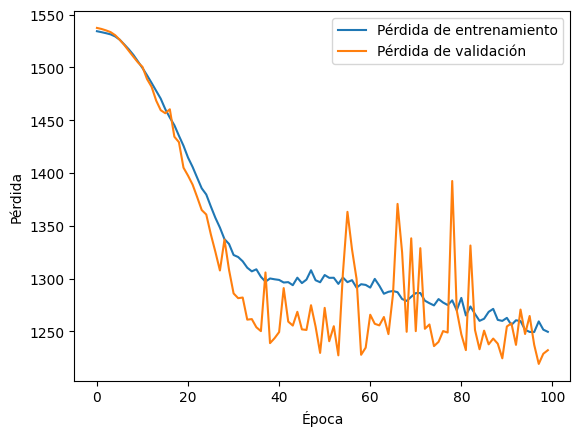

In [12]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [13]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 1192.841356986922
Error Cuadrático Medio (MSE): 3747682.0648839925


# 100 epoch / 100k dades / 3x3 conv / 0.4 dropout / 0.01 l2 / 32 batch

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
# Graficar las pérdidas
plt.plot(history.history['mean_absolute_error'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_mean_absolute_error'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

# Representacion red neuronal


In [ ]:
from graphviz import Digraph

# Crear un nuevo objeto Digraph
dot = Digraph(comment='Red Neuronal')

# Definir los nodos de la red neuronal
dot.node('Input1', 'Input1\n(64)')
dot.node('Input2', 'Input2\n(6)')
dot.node('Concatenate', 'Concatenate\n(70)')
dot.node('Dense1', 'Dense1\n(128)')
dot.node('Dense2', 'Dense2\n(256)')
dot.node('Dense3', 'Dense3\n(512)')
dot.node('Dense4', 'Dense4\n(256)')
dot.node('Dense5', 'Dense5\n(128)')
dot.node('Output', 'Output\n(1)')

# Definir las aristas (conexiones) entre los nodos
# Cambiar de strings a tuplas con las conexiones
edges = [
    ('Input1', 'Concatenate'),
    ('Input2', 'Concatenate'),
    ('Concatenate', 'Dense1'),
    ('Dense1', 'Dense2'),
    ('Dense2', 'Dense3'),
    ('Dense3', 'Dense4'),
    ('Dense4', 'Dense5'),
    ('Dense5', 'Output')
]

# Añadir las aristas a dot
for edge in edges:
    dot.edge(*edge)

# Visualizar y guardar el grafo
dot.format = 'png'  # Formato de salida
dot.render('red_neuronal_grafo', view=True)  # Guardar y mostrar la imagen

'red_neuronal_grafo.png'

# Prova models


In [ ]:
im_train, im_test, ib_train, ib_test, lab_train, lab_test = data.train_test(1000)

In [ ]:
data_model = tf.keras.models.load_model('/content/drive/MyDrive/TFG/model_200_model_gran.h5',
                                   custom_objects={'InputLayer': tf.keras.layers.InputLayer,
                                                   'MeanSquaredError': tf.keras.losses.MeanSquaredError})
data_model.compile(optimizer=opt, loss=los, metrics=metric)

In [ ]:
predictions = data_model.predict([ib_test, im_test], verbose=0)
predictions = np.array(predictions).flatten()


lab_test = np.array(lab_test)
mae = np.mean(np.abs(predictions - lab_test))
mse = np.mean((predictions - lab_test) ** 2)
print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Absoluto Medio (MAE): 1085.9940356206894
Error Cuadrático Medio (MSE): 2914619.9907454997
